Composant IA pour la détection de soudures défectueuses

Ce projet vise à développer un composant d’intelligence artificielle capable de détecter automatiquement la qualité des soudures à partir d’images industrielles. 
Ce composant doit répondre à des critères de fiabilité, de robustesse, d’évaluation rigoureuse et d’explicabilité, en cohérence Confiance.ai.

On va utiliser le Dataset **Renault Welding Dataset** pour ce projet. Ce dataset contient des données sur les soudures de la Renault.

### Schéma d'architecture en phase d'opération

![Architecture Opération](DIAGRAMME.png)


Cette architecture correspond à la mise en production du composant IA pour prédire la confirmité d'une soudre à partir d'une image issue d'un capteur.

On prend une image en entrée(Image capturée par un capteur industriel (caméra RGB)), 
On a la prépare : Objectif : préparer l’image pour le modèle (homogénéité et compatibilité):
Outils utilisés : `Pillow (PIL)`, `NumPy`  :redimensionnement, normalisation, Conversion au format tensoriel si besoin (pour les frameworks IA).

Puis on la passe au modèle de prédiction : Modèle CNN entraîné pour une classification binaire : YOLO pour identifier la boundingbox ou est situé le défaut, puis EfficientNet. Adapté à la classification binaire globale (OK / NOK)
     - Léger, rapide en inférence.
     - Excellente performance avec peu de données (pré-entraîné sur ImageNet)
     - Implémentation simple avec `TensorFlow`, `Keras`, ou `PyTorch`


Le modèle prend en entrée l'image préparée : le réseau de neurones convolutif entrainé pour classifier les images dans deux catégories : conforme : OK et non conforme : NOK. Le modèle retourne une probabilité par classe. On définit un seuil de probabilité avec argmax
Enfin, on a une probabilité associée à chaque classe qui est transformée en décision binaire puis en sortie la prédiction est affichée.

L'objectif est de définir avant tout une décision traçable et fiable en production.


### Schéma d'architecture en entrainement

![Architecture Entrainement](DIAGRAMME1.png)

Cette architecture correspond à la phase où le modèle est construit à partir des données annotées (images de soudures + labels).
On prend en entrée les données annotées des soudures labélisées comme conforme ou non conformes ( OK et NOK) Chargement via `Pandas`, `os`, `PIL` 

puis on va prétraiter les donnéer : redimensionnement, normalisation : Outils utilisés : `PIL`, `NumPy`, `Torchvision.transforms`
Redimensionnement (ex : 224x224)
     - Normalisation des canaux RGB
     - (Optionnel) Data augmentation : rotations, flous, flips

On divise notre dataset complet en deux jeux : un jeu d'entraînement et un jeu de validation par sklearn.model_selection.train_test_split
On utilise ensuite un modèle de réseau de neurones convolutionnel (CNN) par YOLO puis EfficientNet. 
Fonction de perte : `Binary Cross Entropy`
   - Optimiseur : `Adam` ou `SGD`
   - Framework : `PyTorch` ou `TensorFlow`
   - À chaque époque, la perte est réduite et les poids du modèle sont mis à jour
   
   Le modèle apprend par rétropropagation des erreurs sur les images du jeu d'entraînement. Enfin, on obtient un modèle entrainé, prêt à être utilisé pour prédire les labels des images non annotées.

### Schéma d'architecture en évaluation

![Architecture Evaluation](DIAGRAMME3.png)

Ici, on va mesurer la performance du modèle entrainé via différents paramètres.
On prend en entrée notre jeu de test annoté pas encore vu par le modèle.
Permet d’estimer les performances réelles du modèle
   - Chargement via `Pandas`, `PIL`, `torchvision.datasets.ImageFolder`
On prétraite à nouveau les données ( mêmes opérations que lors de l'entraintement)  
Le modèle entrainé précédemment est chargé EfficientNet  
Outils : `torch.load()` (PyTorch), `model.load_weights()` (Keras)
   - Le modèle est mis en mode évaluation (`model.eval()`)
Le modèle prédit la classe ( OK /NOK) pour chaque image du jeu de test.
Le modèle est appliqué sur chaque image
   - En sortie : une probabilité pour chaque classe → convertie en prédiction (`argmax` ou `> 0.5`)
   - Résultats stockés pour comparaison avec les vrais labels
Puis les prédictions sont comparées aux labels réels pour calculer les performances du modèle
Métriques calculées :
     - `accuracy` (taux global de bonnes réponses)
     - `precision`, `recall`, `f1-score`
     - Matrice de confusion
   - Outils : `sklearn.metrics`, `matplotlib.pyplot` (pour la visualisation)
Enfin, on analyse la robustesse du modèle (perturbations, variations de conditions), son explicabilité (SHAP, Grad-CAM…) et on cherche à identifier des cas limites ou ambigus, des cas d'halluciantion etc.
On peut évaluer le modèle sur des images volontairement altérées (floutées, bruitées, tournées)
détection d’écarts de performance selon le type de soudure, la luminosité




### Dataset dérivé 1 – Images floutées (défaut de mise au point)

Ce dataset permet d’évaluer la robustesse du modèle à un défaut courant : un flou gaussien simulant une mauvaise mise au point de la caméra. Cela reflète des conditions de prise de vue dégradées, fréquentes dans un environnement industriel réel.

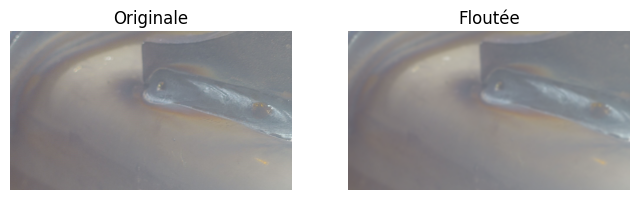

In [10]:
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt

img_path = "c20\operator\sample_151.jpeg"

img = Image.open(img_path)
img_flou = img.filter(ImageFilter.GaussianBlur(radius=6))

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Originale")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(img_flou)
plt.title("Floutée")
plt.axis("off")
plt.show()


### Dataset altéré : flou gaussien (radius = 6)

Dans cette section, une altération par flou gaussien est appliquée à une image issue du dataset de soudure.  
Ce type de dégradation simule des conditions réelles comme un défaut de mise au point, une lentille sale ou un flou de mouvement léger.

**Paramètres d'altération :**
- Méthode : `PIL.ImageFilter.GaussianBlur`
- Radius : 6

**Objectif de l’altération :**
- Évaluer la robustesse du modèle à la perte de netteté
- Identifier l’impact du flou sur les erreurs de classification
- Introduire un KPI spécifique de sensibilité au flou

**Méta-données associées à l'échantillon :**
- `filename` : `sample_151.jpeg`
- `operator` : permet d'analyser la variabilité inter-opérateurs sous flou
- `tool`, `position`, `thickness` : utiles pour croiser la performance sous flou avec des facteurs de production



### Dataset dérivé 2 – Images tournées

Objectif : simuler des cas où la pièce est mal positionnée.
Méthode : appliquer une rotation de l’image
Usage : tester la robustesse du modèle face à l’orientation.


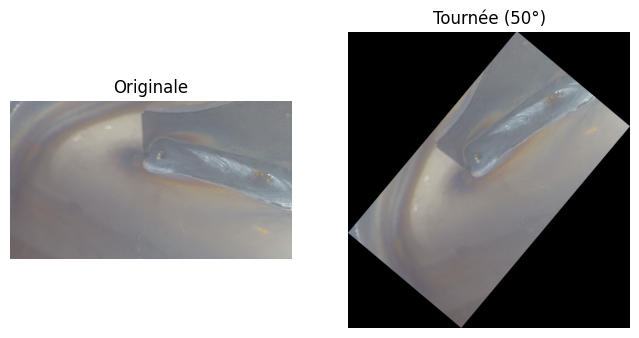

In [14]:
img_path = "c20\operator\sample_151.jpeg"

img = Image.open(img_path)
angle = 50

img_rot = img.rotate(angle, expand=True)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Originale")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(img_rot)
plt.title(f"Tournée ({angle}°)")
plt.axis("off")
plt.show()

### Dataset altéré : rotation d’image (angle = 50°)

Ce traitement applique une rotation de 50° à l’image d’une soudure, pour simuler un cas d’usage dans lequel la caméra ou la pièce est mal orientée.  
Cela permet de tester la invariance du modèle aux changements angulaires dans un contexte réaliste de production.

**Paramètres d'altération :**
- Méthode : `PIL.Image.rotate`
- Angle : 50°
- `expand=True` pour préserver la totalité du contenu après rotation

**Objectif de l’altération :**
- Évaluer la tolérance angulaire du modèle
- Identifier une éventuelle instabilité des prédictions
- Préparer un KPI de robustesse aux rotations

**Méta-données associées à l'échantillon :**
- `filename` : `sample_151.jpeg`
- `position` : la rotation pourrait influencer différemment selon la position de soudure
- `batch` et `type` : à croiser avec les performances post-rotation

### KPI – Robustesse du modèle à une altération par flou gaussien

Ce KPI évalue la capacité du modèle à conserver des prédictions correctes lorsqu’une image subit un flou gaussien simulé.  

**Définition du KPI :**
- Soit une image `x` de label `y`
- On applique un flou gaussien à `x` pour obtenir `x_flou`
- Le modèle fait une prédiction `ŷ` sur `x_flou`


**Paramètres :**
- Radius de flou : `6` (fixe)
- Données d’entrée : sous-ensemble de validation ou de test

**Méta-données associées :**
- `operator` : permet d’évaluer si certains opérateurs produisent des images plus sensibles au flou
- `tool`, `position`, `thickness` : permettent des analyses croisées pour comprendre la variabilité de robustesse



In [ ]:
from PIL import Image, ImageFilter
from model import predict_label 

def compute_kpi_robustesse_flou(image_paths, labels, radius=6):
    correct = 0
    for img_path, true_label in zip(image_paths, labels):
        img = Image.open(img_path)
        img_flou = img.filter(ImageFilter.GaussianBlur(radius=radius))
        pred = predict_label(img_flou) 
        if pred == true_label:
            correct += 1
    return correct / len(image_paths)


ModuleNotFoundError: No module named 'model'

### KPI – Robustesse du modèle à la rotation

Ce KPI permet de mesurer dans quelle mesure le modèle conserve des prédictions correctes lorsque les images subissent une rotation angulaire.  
Cette mesure permet d'évaluer l’invariance directionnelle du modèle vis-à-vis de la position spatiale des pièces à souder.

**Définition du KPI :**
- À chaque image `x` de label `y`, on applique une rotation de `θ` degrés pour obtenir `x_rot`
- On interroge le modèle sur `x_rot`, et on compare la prédiction `ŷ_rot` au label `y`
- Le KPI est défini par la proportion de prédictions correctes après rotation :


**Paramètres :**
- Angle de rotation : 50°
- Image pivotée autour du centre
- `expand=True` pour inclure la totalité de la nouvelle zone

**Méta-données associées :**
- `position` : certaines positions peuvent induire une sensibilité plus forte à la rotation
- `tool`, `type`, `batch` : variables utiles à croiser pour identifier une sensibilité spécifique

**Échantillon attendu :**
```json
{
  "filename": "sample_151.jpeg",
  "true_label": 1,
  "predicted_label_rot": 1,
  "angle": 50,
  "correct": true
}


In [16]:
from PIL import Image
from model import predict_label 

def compute_kpi_robustesse_rotation(image_paths, labels, angle=50):
    correct = 0
    for img_path, true_label in zip(image_paths, labels):
        img = Image.open(img_path)
        img_rot = img.rotate(angle, expand=True)
        pred = predict_label(img_rot) 
        if pred == true_label:
            correct += 1
    return correct / len(image_paths)

ModuleNotFoundError: No module named 'model'

### Interface Python du composant IA

Nous définissons ici un composant IA sous forme de boîte noire.  
Il simule le comportement d’un classifieur, recevant une image en entrée et renvoyant une prédiction simulée.

Ce composant permet de structurer les interactions internes entre les différentes étapes du traitement.

**Entrée :**
- Une image (objet PIL)

**Sortie :**
- Un label simulé (entier : `0` pour bonne soudure, `1` pour défaut)

Ce composant est appelé par les fonctions de calcul des KPI, et pourrait être remplacé ultérieurement par un modèle réel entraîné.


In [18]:
import random

def ia_component_predict(image):
    """
    Interface simulée du composant IA.
    renvoie aléatoirement un label binaire.
    
    Entrée :
        image : une image PIL.Image
    Sortie :
        0 (pas de défaut) ou 1 (défaut)
    """
    return random.choice([0, 1])


### Exemple d’appel à l’interface du composant IA simulé

Ici, nous utilisons une image altérée par flou gaussien, puis nous appelons notre composant IA simulé (`ia_component_predict`) pour obtenir une prédiction.  
Cela permet de tester l’intégration de l’interface dans le pipeline, en prévision de l’intégration d’un vrai modèle ultérieurement.

Cette prédiction simulée est utilisée dans le calcul des KPI définis précédemment.


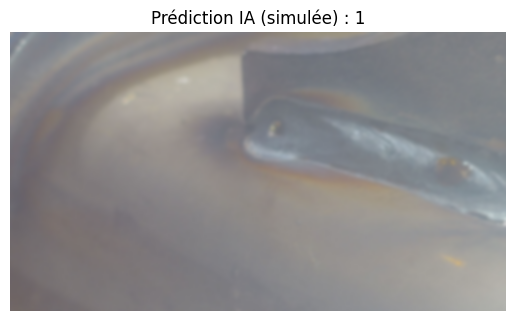

In [20]:
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt

img_path = "c20/operator/sample_151.jpeg"
img = Image.open(img_path)

img_flou = img.filter(ImageFilter.GaussianBlur(radius=6))

# Appel à la boîte noire
prediction = ia_component_predict(img_flou)

plt.imshow(img_flou)
plt.title(f"Prédiction IA (simulée) : {prediction}")
plt.axis("off")
plt.show()


## Conclusion

Ce TP a permis de poser les fondations d’un composant IA destiné à évaluer la qualité de soudures dans un contexte industriel exigeant.  
Plutôt que de développer immédiatement un modèle complexe, l’accent a été mis sur la structure du système, la modélisation des interactions et la formalisation d’indicateurs pertinents.

Les choix d’altérations : flou et rotation sont importants car ils permettent de simuler des variations réelles.
En les intégrant dès cette phase de conception, on anticipe les contraintes futures de robustesse et de résilience du modèle.

La simulation du modèle par une boîte noire aléatoire permet de tester l’ensemble du pipeline d’évaluation sans dépendre de l'entraînement préalable d’un réseau.  
Cela garantit une séparation claire entre architecture fonctionnelle et performance réelle.

Ce TP démontre ainsi qu’il est possible de concevoir un composant rigoureusement défini, modulaire et mesurable, sans dépendre d’un modèle finalisé.  
